In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
from PIL import Image
from IPython.display import clear_output

mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

In [16]:
def preprocess_image(image, mask, target_size=(256, 256)):
    image = tf.image.resize(image, target_size) / 255.0  # Normalize
    mask = tf.image.resize(mask, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image, mask

In [17]:
import tensorflow as tf

def random_rotate(image, label, max_deg=90):
    # 0, 90, 180, 270 중 하나의 회전 각도 선택
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    
    # 회전 수행 (90도 단위로 회전)
    image = tf.image.rot90(image, k=k)
    label = tf.image.rot90(label, k=k)

    return image, label

In [18]:
def data_augmentation(image, label):
    # 좌우 반전
    image = tf.image.random_flip_left_right(image)
    label = tf.image.random_flip_left_right(label)

    # 상하 반전
    image = tf.image.random_flip_up_down(image)
    label = tf.image.random_flip_up_down(label)

    # 회전
    image, label = random_rotate(image, label, max_deg=20)

    # 색상 변화
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)

    return image, label

In [19]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# 데이터셋 로드 함수
def load_dataset(batch_size=8):
    DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')
    img_dir = os.path.join(DATASET_PATH, "train")
    label_dir = os.path.join(DATASET_PATH, "train_labels")

    image_paths = sorted([os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith('.bmp')])
    label_paths = sorted([os.path.join(label_dir, fname) for fname in os.listdir(label_dir) if fname.endswith('.bmp')])

    image_paths = tf.convert_to_tensor(image_paths, dtype=tf.string)
    label_paths = tf.convert_to_tensor(label_paths, dtype=tf.string)

    def load_image(image_path, label_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_bmp(image, channels=3)  # RGB 채널로 디코딩
        image = tf.image.resize(image, (128, 128)) / 255.0  # Normalize

        label = tf.io.read_file(label_path)
        label = tf.image.decode_bmp(label, channels=3)  # RGB로 디코딩
        label = tf.image.resize(label, (128, 128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        label = tf.reduce_sum(label, axis=-1, keepdims=True)  # 그레이스케일로 변환

        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

# 데이터셋 로드
dataset = load_dataset(batch_size=8)

# 배치 데이터를 X, y로 변환
X = []
y = []

for img_batch, lbl_batch in dataset:
    X.append(img_batch.numpy())
    y.append(lbl_batch.numpy())

X = np.concatenate(X, axis=0)  # 모든 배치를 하나의 numpy array로 합침
y = np.concatenate(y, axis=0)

# 훈련 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(240, 128, 128, 3) (60, 128, 128, 3) (240, 128, 128, 1) (60, 128, 128, 1)


In [20]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(ConvBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')
        self.pool = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2))

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.conv2(x)
        return self.pool(x)

class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(DecoderBlock, self).__init__()
        self.upconv = tf.keras.layers.Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same', activation='relu')
        self.conv1 = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')

    def call(self, inputs, skip_connection, training=False):
        x = self.upconv(inputs)
        
        # skip_connection과 크기 맞추기
        if x.shape[1] != skip_connection.shape[1] or x.shape[2] != skip_connection.shape[2]:
            x = tf.image.resize(x, (skip_connection.shape[1], skip_connection.shape[2]))

        x = tf.keras.layers.concatenate([x, skip_connection], axis=-1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [21]:
class VGG16UNet(tf.keras.Model):
    def __init__(self):
        super(VGG16UNet, self).__init__()
        
        # VGG16 모델을 백본으로 사용, include_top=False로 포함시켜서 FC 레이어 제외
        vgg16 = tf.keras.applications.VGG16(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
        layer_outputs = [vgg16.layers[i].output for i in [2, 5, 9, 13, 17]]
        self.encoder = tf.keras.Model(inputs=vgg16.input, outputs=layer_outputs)
        
        # Decoder 블록들
        self.center = ConvBlock(1024)
        self.decoder4 = DecoderBlock(512)
        self.decoder3 = DecoderBlock(256)
        self.decoder2 = DecoderBlock(128)
        self.decoder1 = DecoderBlock(64)
        self.output_conv = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')
    
    def call(self, inputs, training=False):
        # Encoder에서 특징 추출
        enc1, enc2, enc3, enc4, bottleneck = self.encoder(inputs, training=training)
        
        # Center block
        bottleneck = self.center(bottleneck, training=training)
        
        # Decoder와 Skip connection을 통한 재구성
        dec4 = self.decoder4(bottleneck, enc4, training=training)
        dec3 = self.decoder3(dec4, enc3, training=training)
        dec2 = self.decoder2(dec3, enc2, training=training)
        dec1 = self.decoder1(dec2, enc1, training=training)
        
        # Output layer
        outputs = self.output_conv(dec1)
        
        return outputs

In [22]:
# 모델 생성
model = VGG16UNet()
model.build(input_shape=(None, 128, 128, 3))
model.summary()

Model: "vg_g16u_net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         [(None, 128, 128, 64), (N 14714688  
_________________________________________________________________
conv_block_2 (ConvBlock)     multiple                  14157824  
_________________________________________________________________
decoder_block_8 (DecoderBloc multiple                  11798016  
_________________________________________________________________
decoder_block_9 (DecoderBloc multiple                  2949888   
_________________________________________________________________
decoder_block_10 (DecoderBlo multiple                  737664    
_________________________________________________________________
decoder_block_11 (DecoderBlo multiple                  184512    
_________________________________________________________________
conv2d_32 (Conv2D)           multiple                

In [26]:
# Dice coefficient 계산 함수
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    
    # Dice coefficient는 0과 1 사이의 값이어야 하므로 1을 넘지 않도록 처리
    dice = tf.clip_by_value(dice, 0.0, 1.0)  # dice 값이 0과 1 사이로 유지되도록 처리
    
    tf.print("Dice coefficient:", dice)  # 디버깅용 출력
    return 1 - dice  # Dice loss는 1에서 dice 값을 빼는 방식으로 계산

# IoU (Intersection over Union) 계산 함수
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # 예측 값과 실제 값의 교집합
    intersection = tf.reduce_sum(y_true * y_pred)
    
    # 예측 값과 실제 값의 합집합
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    # IoU 계산 (교집합 / 합집합)
    iou = intersection / (union + 1e-6)  # 1e-6은 나누기 0을 방지하기 위한 작은 값
    return iou

# combined loss 함수 (Dice Loss + Binary Crossentropy)
def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)  # Dice loss 호출
    return bce + dice

# 옵티마이저 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)

# 모델 컴파일
model.compile(optimizer=optimizer, loss=combined_loss, metrics=['accuracy', iou_metric, dice_loss])

In [27]:
def plot_metrics(history):
    # Accuracy 그래프
    plt.figure(figsize=(12, 8))
    
    # Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # IoU (Intersection over Union) 그래프
    plt.subplot(2, 2, 2)
    plt.plot(history.history['iou_metric'], label='Train IoU')
    plt.plot(history.history['val_iou_metric'], label='Validation IoU')
    plt.title('IoU Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Dice Loss 그래프
    plt.subplot(2, 2, 3)
    plt.plot(history.history['dice_loss'], label='Train Dice Loss')
    plt.plot(history.history['val_dice_loss'], label='Validation Dice Loss')
    plt.title('Dice Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/10
Dice coefficient: 0.792683244
Dice coefficient: 0.792683244
1/8 [==>...........................] - ETA: 14s - loss: 5.2037 - accuracy: 0.7903 - iou_metric: 0.6566 - dice_loss: 0.2073Dice coefficient: 0.783123851
Dice coefficient: 0.783123851
2/8 [======>.......................] - ETA: 2s - loss: 5.6184 - accuracy: 0.7875 - iou_metric: 0.6501 - dice_loss: 0.2121 Dice coefficient: 0.786055624
Dice coefficient: 0.786055624
3/8 [==========>...................] - ETA: 2s - loss: 5.7749 - accuracy: 0.7860 - iou_metric: 0.6492 - dice_loss: 0.2127Dice coefficient: 0.815690279
Dice coefficient: 0.815690279
4/8 [==============>...............] - ETA: 1s - loss: 5.8372 - accuracy: 0.7819 - iou_metric: 0.6591 - dice_loss: 0.2056Dice coefficient: 0.804971933
Dice coefficient: 0.804971933
5/8 [=================>............] - ETA: 1s - loss: 5.6964 - accuracy: 0.7806 - iou_metric: 0.6620 - dice_loss: 0.2035Dice coefficient: 0.808658183
Dice coefficient: 0.808658183
6/8 [=================

6/8 [=====================>........] - ETA: 0s - loss: 1.8842 - accuracy: 0.6267 - iou_metric: 0.8571 - dice_loss: 0.0771Dice coefficient: 0.960653663
Dice coefficient: 0.960653663
7/8 [=========================>....] - ETA: 0s - loss: 1.7744 - accuracy: 0.6228 - iou_metric: 0.8667 - dice_loss: 0.0717Dice coefficient: 0.951344371
Dice coefficient: 0.951344371
8/8 [==============================] - ETA: 0s - loss: 1.7454 - accuracy: 0.6211 - iou_metric: 0.8718 - dice_loss: 0.0688Dice coefficient: 0.939182937
Dice coefficient: 0.939182937
Dice coefficient: 0.95908618
Dice coefficient: 0.95908618
8/8 [==============================] - 4s 466ms/step - loss: 1.7454 - accuracy: 0.6211 - iou_metric: 0.8718 - dice_loss: 0.0688 - val_loss: 1.1797 - val_accuracy: 0.5942 - val_iou_metric: 0.9034 - val_dice_loss: 0.0509
Epoch 6/10
Dice coefficient: 0.948280811
Dice coefficient: 0.948280811
1/8 [==>...........................] - ETA: 3s - loss: 0.9784 - accuracy: 0.6007 - iou_metric: 0.9016 - dice_

4/8 [==============>...............] - ETA: 1s - loss: -2.8537 - accuracy: 0.4431 - iou_metric: 1.1904 - dice_loss: 0.0000e+00Dice coefficient: 1
Dice coefficient: 1
5/8 [=================>............] - ETA: 1s - loss: -2.9128 - accuracy: 0.4393 - iou_metric: 1.1934 - dice_loss: 0.0000e+00Dice coefficient: 1
Dice coefficient: 1
6/8 [=====================>........] - ETA: 0s - loss: -2.9633 - accuracy: 0.4341 - iou_metric: 1.1962 - dice_loss: 0.0000e+00Dice coefficient: 1
Dice coefficient: 1
7/8 [=========================>....] - ETA: 0s - loss: -2.9846 - accuracy: 0.4287 - iou_metric: 1.2014 - dice_loss: 0.0000e+00Dice coefficient: 1
Dice coefficient: 1
8/8 [==============================] - ETA: 0s - loss: -2.9849 - accuracy: 0.4253 - iou_metric: 1.2057 - dice_loss: 0.0000e+00Dice coefficient: 1
Dice coefficient: 1
Dice coefficient: 1
Dice coefficient: 1
8/8 [==============================] - 4s 486ms/step - loss: -2.9849 - accuracy: 0.4253 - iou_metric: 1.2057 - dice_loss: 0.0000e+

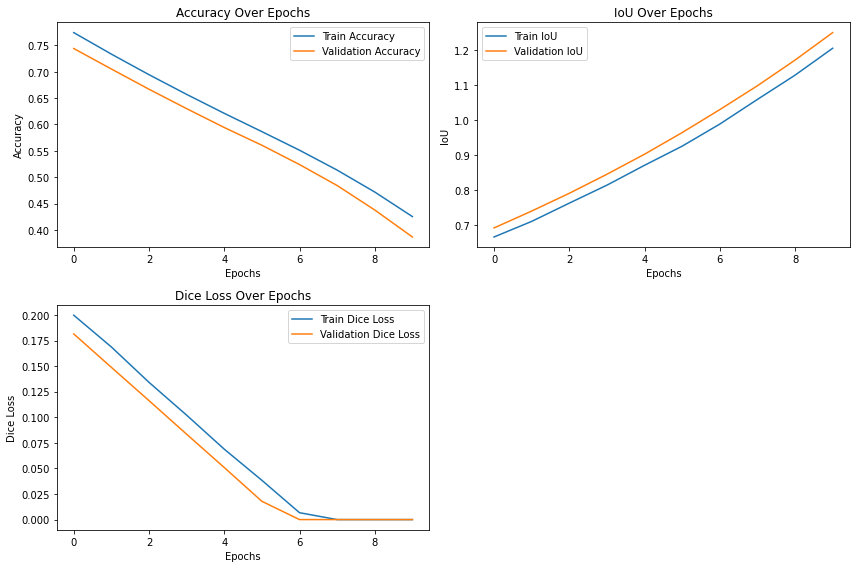

In [28]:
# 모델 학습
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=10, 
    batch_size=32, 
)

# 훈련이 끝난 후 plot_metrics 함수 호출
plot_metrics(history)

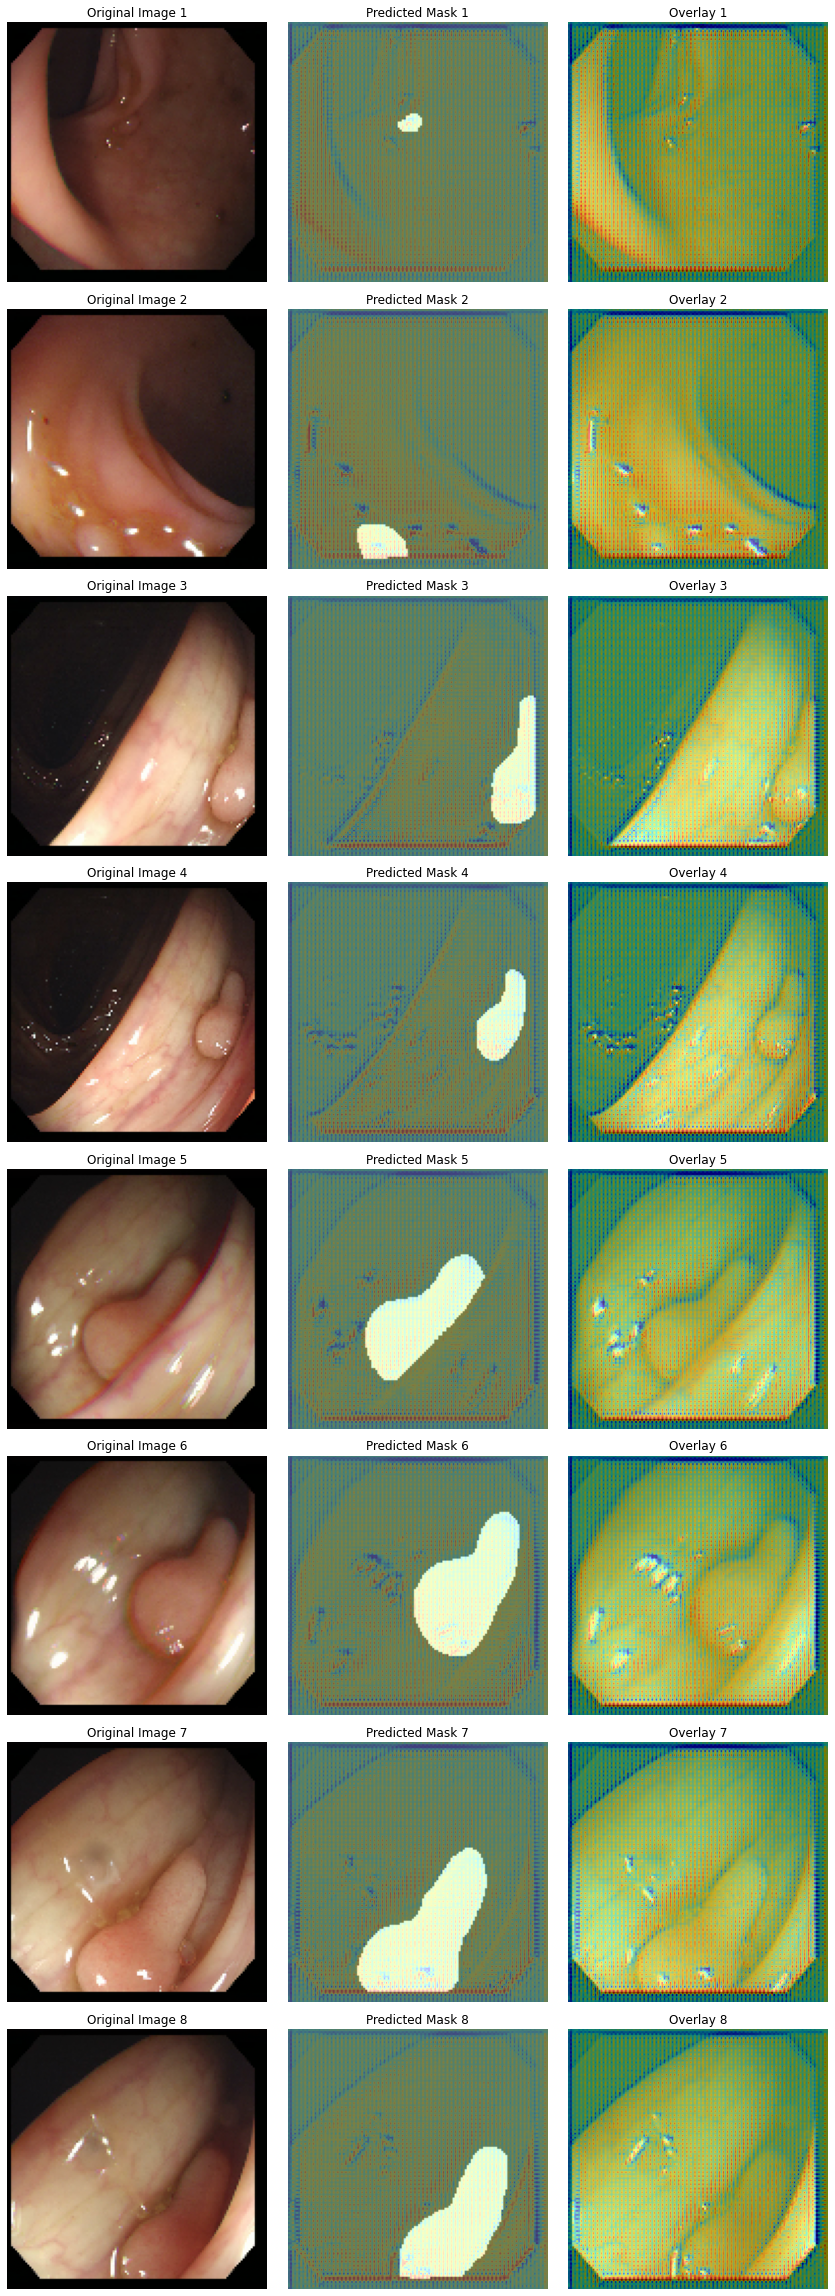

In [29]:
for images, labels in dataset.take(1):
    # 예측된 마스크는 모델을 사용해 예측
    predicted_masks = model(images, training=False)  # 모델 예측 (배치 내 모든 이미지)
    
    # 각 이미지에 대한 true mask와 predicted mask 가져오기
    true_masks = labels[..., 0]  # 실제 마스크는 1채널로 되어 있음
    predicted_masks = predicted_masks[..., 0]  # 예측된 마스크

    # 시각화
    plot_predictions_batch(images.numpy(), predicted_masks.numpy(), true_masks.numpy())